# Titanic - Machine Learning from Disaster
  - Start here! Predict survival on the Titanic and get familiar with ML basics
  - https://www.kaggle.com/competitions/titanic

# 0. 패키지

In [41]:
import os
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from torch.utils.tensorboard import SummaryWriter


from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 데이터셋

## 1.0 컬럼별 속성
![columns](./img/columns.png)

## 1.1 Train

In [43]:
train_df = pd.read_csv('train.csv')
train_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 1.2 Test

In [44]:
test_df = pd.read_csv('test.csv')
test_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


## 1.3 Describe
  - Survived - 전체 인원 중 생존률 약 38.4%
  - SibSp - 대부분이 형제/자매, 배우자와 함께 탑승
  - Parch - 부모, 자식과 함께 탑승한 사람이 적지 않음

In [45]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## 1.4 결측치 (NaN)
  - Age : 나이 확인 X
  - Cabin : 선원이 아닌 사람
  - Embarked : 승선지 확인 X

In [6]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## 1.5 데이터 정제
  - 삭제 : PassengerId, Name, Ticket
  - 수정
    - Sex : 0 = Male / 1 = Female 으로 변경
    - Cabin : IsCabin (0 = No / 1 = Yes) 으로 변경
    - Embarked : Emb_S, Emb_C, Emb_Q (One-hot Encoding) 로 변경
  - 결측치 처리
    - Cabin - IsCabin 변경하면서 해결
    - Embarked - One-hot Encoding 변경하면서 해결
    - Age
      - fillna() - 중간값, ffill, bfill
      - ML을 통한 fill

In [46]:
def df_refine(df) :
    # Remove PassengerId, Name, Ticket
    df.index = df['PassengerId']

    df = df.drop(['PassengerId', 'Name', 'Ticket'], axis=1)

    # Change Sex (Label Encoding) - 0 = Male / 1 = Female
    df['Sex'] = (df['Sex'] == 'female').astype(np.int8)

    # Change Cabin to IsCabin - 0 = No / 1 = Yes
    df['IsCabin'] = df['Cabin'].isnull().astype(np.int8)
    df = df.drop('Cabin', axis = 1)

    # Change Embarked - One-hot Encoding
    embarked = pd.get_dummies(df['Embarked'])
    embarked.columns = ['Emb_{}'.format(emb) for emb in embarked.columns]
    df = pd.concat([df, embarked], axis=1)
    df = df.drop('Embarked', axis=1)

    return df

train_df = df_refine(train_df)
test_df = df_refine(test_df)

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   IsCabin   891 non-null    int8   
 8   Emb_C     891 non-null    uint8  
 9   Emb_Q     891 non-null    uint8  
 10  Emb_S     891 non-null    uint8  
dtypes: float64(2), int64(4), int8(2), uint8(3)
memory usage: 53.1 KB


# 2. EDA

## 2.1 상관계수 (Correlation)
1. Pclass - Survived (-0.338) : Pclass ↓ (객실 등급 ↑) - 생존 경향 ↑
2. Fare - Pclass (-0.550) : 요금 ↑ - Pclass ↓ (객실 등급 ↑)
3. Fare - Survived (0.257) : 요금 ↑ - 생존 경향 ↑
    - 1 + 2 : 요금 ↑ -> Pclass ↓ (객실 등급 ↑) -> 생존 경향 ↑
4. Age - Pclass (-0.369) : 나이 ↑ - Pclass ↓ (객실 등급 ↑)
5. SibSp - Age (-0.308) : 배우자, 형제/자매 동승자 ↑ - 나이 ↓
6. Parch - Age (-0.189) : 부모/자식 동승자 ↑ - 나이 ↓
7. SibSp - Parch (0.415) : 배우자, 형제/자매 동승자 ↑ - 부모/자식 동승자 ↑
    - 5 + 6 + 7 : 가족 단위의 탑승객이 적지 않음

In [9]:
train_df.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,IsCabin,Emb_C,Emb_Q,Emb_S
Survived,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.316912,0.168240,0.003650,-0.155660
Pclass,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.725541,-0.243292,0.221009,0.081720
Sex,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.140391,0.082853,0.074115,-0.125722
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.249732,0.036261,-0.022405,-0.032523
SibSp,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.040460,-0.059528,-0.026354,0.070941
Parch,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,-0.036987,-0.011069,-0.081228,0.063036
Fare,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.482075,0.269335,-0.117216,-0.166603
IsCabin,-0.316912,0.725541,-0.140391,-0.249732,0.040460,-0.036987,-0.482075,1.000000,-0.208528,0.129572,0.110087
Emb_C,0.168240,-0.243292,0.082853,0.036261,-0.059528,-0.011069,0.269335,-0.208528,1.000000,-0.148258,-0.778359
Emb_Q,0.003650,0.221009,0.074115,-0.022405,-0.026354,-0.081228,-0.117216,0.129572,-0.148258,1.000000,-0.496624


## 2.2 주요 속성 파악

### 2.2.1 Survived
  - 0 = No - 사망 / 1 = Yes - 생존

#### 2.2.1.1 사망자 - 생존자 수

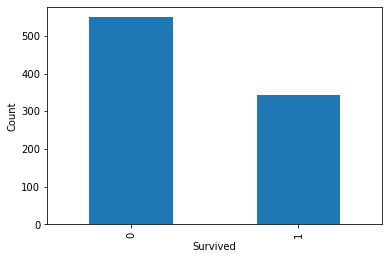

In [10]:
train_df['Survived'].value_counts().plot(kind='bar')

plt.xlabel('Survived')
plt.ylabel('Count')

plt.show()

#### 2.2.1.2 비율

In [11]:
train_df['Survived'].value_counts() / len(train_df) * 100

0    61.616162
1    38.383838
Name: Survived, dtype: float64

### 2.2.2 Pclass
  - 1 = 1st / 2 = 2nd / 3 = 3rd

#### 2.2.2.1 등급별 탑승자

In [12]:
train_df.groupby('Pclass')['Survived'].count()

Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64

#### 2.2.2.2 등급별 생존자 수

In [13]:
train_df.groupby('Pclass')['Survived'].sum()

Pclass
1    136
2     87
3    119
Name: Survived, dtype: int64

#### 2.2.2.3 등급별 생존자 비율

In [14]:
train_df.groupby('Pclass')['Survived'].mean() * 100

Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64

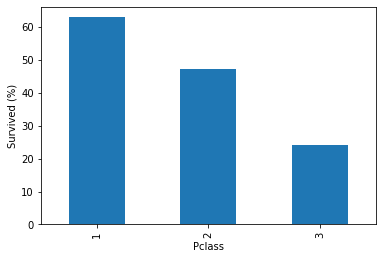

In [15]:
(train_df.groupby('Pclass')['Survived'].mean() * 100).plot(kind='bar')

plt.ylabel('Survived (%)')

plt.show()

### 2.2.3 Sex
  - 0 = Male / 1 = Female

#### 2.2.3.1 전체 탑승자 수

In [16]:
train_df.groupby('Sex')['Survived'].count()

Sex
0    577
1    314
Name: Survived, dtype: int64

#### 2.2.3.2 성별별 생존자 수

In [17]:
train_df.groupby(['Survived', 'Sex'])['Survived'].count()

Survived  Sex
0         0      468
          1       81
1         0      109
          1      233
Name: Survived, dtype: int64

### 2.2.4 Age
  - 20~40세의 탑승자가 가장 많음

#### 2.2.4.1 커널 밀도 함수

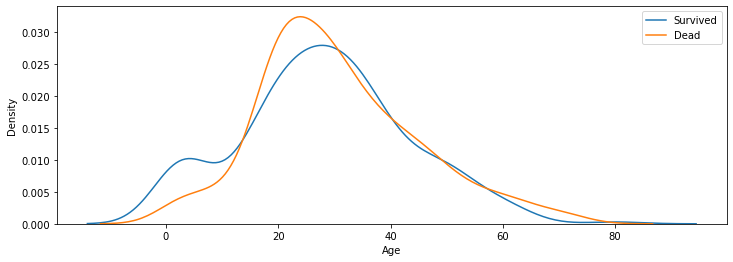

In [18]:
plt.figure(figsize=(12,4))

sns.kdeplot(x=train_df[train_df['Survived'] == 1]['Age'])
sns.kdeplot(x=train_df[train_df['Survived'] == 0]['Age'])

plt.legend(['Survived', 'Dead'])

plt.show()

#### 2.2.4.2 SibSp, Parch 와의 관계
  - Age ↓ -> SibSp, Parch ↑ 
  - 나이가 어릴수록 동승자가 많음

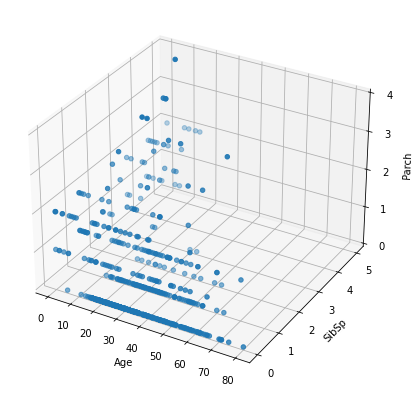

In [19]:
fig = plt.figure(figsize=(7,7))
ax = plt.axes(projection='3d')

X = train_df['Age']
Y = train_df['SibSp']
Z = train_df['Parch']

ax.scatter(X, Y, Z)

ax.set_zlim(0, 4)
ax.set_zticks([0, 1, 2, 3, 4])

ax.set_xlabel('Age')
ax.set_ylabel('SibSp')
ax.set_zlabel('Parch')

plt.show()

### 2.2.5 Sex + Pclass - Survived
  - Female + 좌석 등급 ↑ -> 대부분 생존
  - Male + 좌석 등급 ↓ -> 대부분 사망

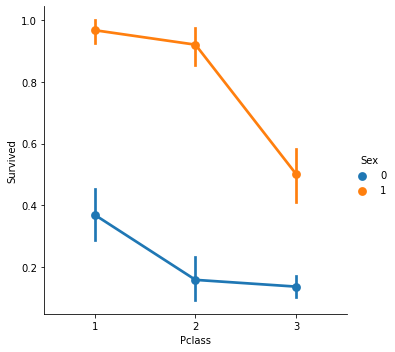

In [20]:
sns.catplot(x='Pclass', y='Survived', hue='Sex', kind='point', data=train_df)

plt.show()

# 3. 모델

## 3.1 Linear_4
  - inputs -> 32 -> 128 -> 16 -> outputs
  - ReLU

In [20]:
class Linear_4(nn.Module) :
    def __init__(self, inputs, outputs) :
        super().__init__()

        self.linear1 = nn.Linear(inputs, 32)
        self.linear2 = nn.Linear(32, 128)
        self.linear3 = nn.Linear(128, 16)
        self.linear4 = nn.Linear(16, outputs)
        
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.relu(self.linear3(x))
        x = self.linear4(x)

        return x

## 3.2 Linear_2
  - inputs -> 32 -> outputs
  - ReLU

In [21]:
class Linear_2(nn.Module) :
    def __init__(self, inputs, outputs) :
        super().__init__()

        self.linear1 = nn.Linear(inputs, 32)
        self.linear2 = nn.Linear(32, outputs)
        
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.relu(self.linear1(x))
        x = self.linear2(x)

        return x

## 3.3 Linear_1
  - inputs -> outputs

In [22]:
class Linear_1(nn.Module) :
    def __init__(self, inputs, outputs) :
        super().__init__()

        self.linear1 = nn.Linear(inputs, outputs)

    def forward(self, x) :
        x = self.linear1(x)

        return x

## 3.4 Logistic Regression
  - inputs -> outputs(1)
  - Sigmoid

In [21]:
class Logistic(nn.Module) :
    def __init__(self, inputs, outputs=1) :
        super().__init__()

        self.linear = nn.Linear(inputs, outputs)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x) :
        x = self.linear(x)
        x = self.sigmoid(x)
        x = x.view(-1)

        return x

## 3.5 Scikit-Learn

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# 4. Age 제외 학습
  - 최적 모델 탐색

## 4.1 데이터셋 변환

In [22]:
rs = 22
bs = 64

In [26]:
train1 = train_df.drop('Age', axis=1)

data = train1.drop('Survived', axis=1)
target = train1['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=rs)

In [23]:
def convert_train_dataset(df_X, df_Y) :
    data = df_X.to_numpy()
    label = df_Y.to_numpy()

    return TensorDataset(torch.Tensor(data), torch.Tensor(label))

In [28]:
train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

In [29]:
train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

## 4.2 학습 준비

In [30]:
epochs = 3000
lr = 0.001

### 4.2.1 Linear

In [75]:
def train(model, criterion, optimizer, epoch, train_dataloader, log=True) :
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets.long())
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = correct / total * 100.
    avg_loss = train_loss / total

    if log and epoch % 5 == 4 :
        print('[ Train Epoch : {} ]'.format(epoch + 1))
        print('Train Accuracy : {}'.format(train_accuracy))
        print('Train Average Loss : {}'.format(avg_loss))

    return (train_accuracy, avg_loss)

def validate(model, criterion, epoch, val_dataloader, log=True) :
    model.eval()
    
    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(val_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets.long()).item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = correct / total * 100.
    avg_loss = val_loss / total

    if log and epoch % 5 == 4 :
        print('[ Validate Epoch : {} ]'.format(epoch + 1))
        print('Accuracy : {}'.format(accuracy))
        print('Average Loss : {}'.format(avg_loss))

    return (accuracy, avg_loss)

In [82]:
model = Linear_4(len(train1.columns)-1, 2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

### 4.2.2 Logistic Regression

In [28]:
def logistic_train(model, criterion, optimizer, epoch, train_dataloader, log=True) :
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        predicted = outputs.round()

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    train_accuracy = correct / total * 100.
    avg_loss = train_loss / total

    if log and epoch % 5 == 4 :
        print('[ Train Epoch : {} ]'.format(epoch + 1))
        print('Train Accuracy : {}'.format(train_accuracy))
        print('Train Average Loss : {}'.format(avg_loss))

    return (train_accuracy, avg_loss)

def logistic_validate(model, criterion, epoch, val_dataloader, log=True) :
    model.eval()
    
    val_loss = 0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(val_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        val_loss += criterion(outputs, targets).item()
        predicted = outputs.round()

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    accuracy = correct / total * 100.
    avg_loss = val_loss / total

    if log and epoch % 5 == 4 :
        print('[ Validate Epoch : {} ]'.format(epoch + 1))
        print('Accuracy : {}'.format(accuracy))
        print('Average Loss : {}'.format(avg_loss))

    return (accuracy, avg_loss)

In [32]:
model = Logistic(len(train1.columns)-1).to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

## 4.3 학습

### 4.3.1 torch

In [30]:
def run(model, criterion, optimizer, epochs, train_method, val_method) :
    writer = SummaryWriter()

    for i in tqdm(range(epochs)) :
        train_acc, train_loss = train_method(model, criterion, optimizer, i, train_dataloader, log=False)
        val_acc, val_loss = val_method(model, criterion, i, val_dataloader, log=False)
            
        writer.add_scalar('Acc/Train', train_acc, i)
        writer.add_scalar('Loss/Train', train_loss, i)
        
        writer.add_scalar('Acc/Val', val_acc, i)
        writer.add_scalar('Loss/Val', val_loss, i)
    
    writer.flush()
    writer.close()

In [34]:
run(model, criterion, optimizer, epochs)

100%|██████████| 3000/3000 [00:53<00:00, 55.99it/s]


### 4.3.2 sklearn

In [73]:
rf = RandomForestClassifier()
log = LogisticRegression(max_iter = epochs)
dt = DecisionTreeClassifier()

for sk_model, sk_name in zip([rf, log, dt], ['RandomForest', 'Logistic', 'DecisionTree']) :
    sk_model.fit(train_X, train_Y)

    pred_Y = sk_model.predict(val_X)
    print(sk_name)
    print(accuracy_score(pred_Y, val_Y))

RandomForest
0.7877094972067039
Logistic
0.776536312849162
DecisionTree
0.7932960893854749


## 결과
![Torch Accuracy](./img/model-accuracy.png)
- epochs : 3000, learning rate : 0.001 기준
- Validate 최고 정확도
  - Torch
    - Linear_1 : 81.56 %
    - Linear_2 : 79.33 %
    - Linear_4 : 82.12 %
    - Logistic : 82.68 %
  - sklearn
    - RandomForest : 78.77 %
    - LogisticRegression : 77.65 %
    - DecisionTree : 79.33 %

- Torch - Logistic 모델로 결정

# 5. Age 시나리오

## 5.1 fillna - Median

In [37]:
train1 = train_df.fillna(train_df.median())
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   IsCabin   891 non-null    int8   
 8   Emb_C     891 non-null    uint8  
 9   Emb_Q     891 non-null    uint8  
 10  Emb_S     891 non-null    uint8  
dtypes: float64(2), int64(4), int8(2), uint8(3)
memory usage: 46.2 KB


In [38]:
data = train1.drop('Survived', axis=1)
target = train1['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=rs)

In [41]:
train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

In [45]:
model1 = Logistic(len(train_X.columns))
optimizer = optim.SGD(model1.parameters(), lr=lr)
criterion = nn.BCELoss()

model1

Logistic(
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [46]:
run(model1, criterion, optimizer, epochs)

100%|██████████| 3000/3000 [00:43<00:00, 69.56it/s]


## 5.2 fillna - ffill

In [49]:
train2 = train_df.fillna(method='ffill')
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   IsCabin   891 non-null    int8   
 8   Emb_C     891 non-null    uint8  
 9   Emb_Q     891 non-null    uint8  
 10  Emb_S     891 non-null    uint8  
dtypes: float64(2), int64(4), int8(2), uint8(3)
memory usage: 46.2 KB


In [50]:
data = train2.drop('Survived', axis=1)
target = train2['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=rs)

In [51]:
train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

In [52]:
model2 = Logistic(len(train_X.columns))
optimizer = optim.SGD(model2.parameters(), lr=lr)
criterion = nn.BCELoss()

model2

Logistic(
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [53]:
run(model2, criterion, optimizer, epochs)

100%|██████████| 3000/3000 [00:37<00:00, 80.91it/s]


## 5.3 fillna - bfill

In [54]:
train3 = train_df.fillna(method='bfill')
train3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   IsCabin   891 non-null    int8   
 8   Emb_C     891 non-null    uint8  
 9   Emb_Q     891 non-null    uint8  
 10  Emb_S     891 non-null    uint8  
dtypes: float64(2), int64(4), int8(2), uint8(3)
memory usage: 46.2 KB


In [55]:
data = train3.drop('Survived', axis=1)
target = train3['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=rs)

In [56]:
train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

In [58]:
model3 = Logistic(len(train_X.columns))
optimizer = optim.SGD(model3.parameters(), lr=lr)
criterion = nn.BCELoss()

model3

Logistic(
  (linear): Linear(in_features=10, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [59]:
run(model3, criterion, optimizer, epochs)

100%|██████████| 3000/3000 [00:37<00:00, 79.71it/s]


## 5.4 모델을 통한 결측치 보간
  - KNNImputer 를 사용해 예측

### 5.4.1 보간

In [107]:
from sklearn.impute import KNNImputer

impute_age = KNNImputer()
train4 = train_df.copy()

train4['Age'] = impute_age.fit_transform(train4)[:, 3].astype(np.int8)
train4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int8   
 3   Age       891 non-null    int8   
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   IsCabin   891 non-null    int8   
 8   Emb_C     891 non-null    uint8  
 9   Emb_Q     891 non-null    uint8  
 10  Emb_S     891 non-null    uint8  
dtypes: float64(1), int64(4), int8(3), uint8(3)
memory usage: 40.2 KB


### 5.4.2 보간 전후 비교

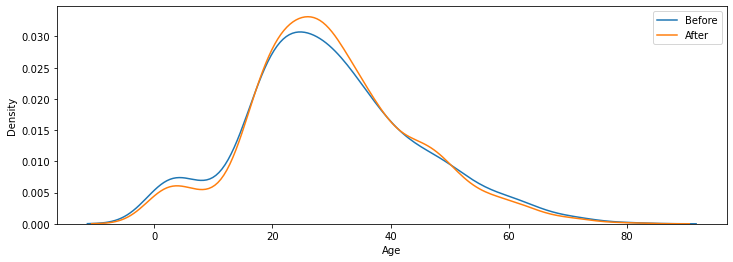

In [110]:
plt.figure(figsize=(12,4))

sns.kdeplot(x=train_df['Age'])
sns.kdeplot(x=train4['Age'])

plt.legend(['Before', 'After'])

plt.show()

### 5.4.3 학습

In [111]:
data = train4.drop('Survived', axis=1)
target = train4['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2, shuffle=True, random_state=rs)

In [112]:
train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

In [117]:
model4 = Logistic(len(train_X.columns))
optimizer = optim.SGD(model4.parameters(), lr=lr)
criterion = nn.BCELoss()

model4

run(model4, criterion, optimizer, epochs)

100%|██████████| 3000/3000 [00:39<00:00, 75.03it/s]


## 5.5 결과
![Age-Impute](./img/age%20impute.png)

- Validate 최고점
  - 제외 : 82.12 %
  - 중간값 : 79.89 %
  - ffill : 78.77 %
  - bfill : 79.89 %
  - KNNImputer : 80.45 %

- 보간보다 제외하는게 결과가 더 좋음

# 6. 최종
  - 모델 : Torch - Logistic
  - Age 제외

## 6.1 데이터셋

In [25]:
data = train_df.drop(['Survived', 'Age'], axis=1)
target = train_df['Survived']

train_X, val_X, train_Y, val_Y = train_test_split(data, target, test_size=0.2)

train_dataset = convert_train_dataset(train_X, train_Y)
val_dataset = convert_train_dataset(val_X, val_Y)

train_dataloader = DataLoader(train_dataset, batch_size=bs)
val_dataloader = DataLoader(val_dataset, batch_size=bs)

## 6.2 학습 준비

In [83]:
def run(model, criterion, optimizer, epochs, train_method, val_method, model_name) :
    writer = SummaryWriter()
    save_acc = 0

    for i in tqdm(range(epochs)) :
        train_acc, train_loss = train_method(model, criterion, optimizer, i, train_dataloader, log=False)
        val_acc, val_loss = val_method(model, criterion, i, val_dataloader, log=False)
        
        if val_acc > save_acc :
            save_acc = val_acc
            torch.save(model, './checkpoints/Logistic_{}.pt'.format(model_name))

        writer.add_scalar('Acc/Train', train_acc, i)
        writer.add_scalar('Loss/Train', train_loss, i)
        
        writer.add_scalar('Acc/Val', val_acc, i)
        writer.add_scalar('Loss/Val', val_loss, i)
    
    writer.flush()
    writer.close()

## 6.3 학습
  - 최적의 learning_rate 탐색
  - lr별로 정확도가 가장 높을 때의 상태를 저장

In [84]:
lrs = [0.01, 0.002, 0.001, 0.0005]
epochs = 5000

if not os.path.exists('checkpoints') :
    os.mkdir('checkpoints')

for lr in lrs :
    model = Logistic(len(train_X.columns))
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)

    run(model, criterion, optimizer, epochs, logistic_train, logistic_validate, str(lr))

100%|██████████| 5000/5000 [01:17<00:00, 64.52it/s]


## 6.4 결과
![lr-accuracy](./img/lr-accuracy.png)
- Validate 기준
  - 0.01 : 78.21 %
  - 0.002 : 78.21 %
  - 0.001 : 80.45 %
  - 0.0005 : 81.56 %
- 0.0005 를 채택

# 7. 제출 csv 생성

In [85]:
model = torch.load('checkpoints/Logistic_0.0005.pt')
model = model.to(device)

In [87]:
#test_df = test_df.drop('Age', axis=1)

test_dataset = TensorDataset(torch.Tensor(test_df.to_numpy()))
test_dataloader = DataLoader(test_dataset, batch_size=bs)

In [88]:
def create_submission(model, dataloader) :
    model.eval()
    
    survived = []

    for data in dataloader :
        data = data[0].to(device)

        outputs = model(data)
        predicted = outputs.round().detach().int().numpy()

        survived.extend(predicted)
        
    return pd.DataFrame({'Survived':survived})

In [89]:
submission_df = create_submission(model, test_dataloader)
submission_df.index = test_df.index

submission_df.to_csv('submission.csv')

submission_df

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0
